<a href="https://colab.research.google.com/github/PinRay22/BA/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 不要動 numpy/pandas/scikit-learn，改用 Colab 內建
# 只安裝你確定需要的東西，並避免帶入它們的依賴
!pip install -q torch==2.8.0 --no-deps
!pip install -q matplotlib==3.9.2 --no-deps



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB ? eta 0:00:00


In [5]:
!pip uninstall -y torchvision torchaudio torchtext xformers
!pip install -q torch==2.2.2+cu121 --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 MB ? eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires torchvision>=0.11, which is not installed.
timm 1.0.20 requires torchvision, which is not installed.


In [17]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounted at /content/drive
✅ 在 Drive 找到檔案： ['/content/drive/MyDrive/studentInfo.csv', '/content/drive/MyDrive/studentVle.csv', '/content/drive/MyDrive/studentAssessment.csv']
✅ 讀取成功： 32593 10655280 173912
✅ 切分完成：train/valid/test 學生數 = 18251/3911/3912
資料張數： (479050, 4, 5) (479050, 2) | (102493, 4, 5) (102493, 2) | (102019, 4, 5) (102019, 2)
🖥️ 使用裝置： cuda
[LSTM] Epoch 1/5 | train MSE=0.7366 | valid MSE=0.8542
[LSTM] Epoch 2/5 | train MSE=0.7297 | valid MSE=0.8549
[LSTM] Epoch 3/5 | train MSE=0.7281 | valid MSE=0.8551
[LSTM] Epoch 4/5 | train MSE=0.7271 | valid MSE=0.8531
[LSTM] Epoch 5/5 | train MSE=0.7259 | valid MSE=0.8561
[VAE ] Epoch 1/5 | train REC=0.7468 KLD=1.0613 | valid REC=0.8611
[VAE ] Epoch 2/5 | train REC=0.7328 KLD=1.2270 | valid REC=0.8589
[VAE ] Epoch 3/5 | train REC=0.7308 KLD=1.1701 | valid REC=0.8566
[VAE ] Epoch 4/5 | train REC=0.7293 KLD=1.1294 | valid REC=0.8546
[VAE ] Epoch 5/5 | train REC=0.7280 KLD=1.0754 | valid REC=0.8550

========== 評估結果（原始尺度） ==========
LSTM  

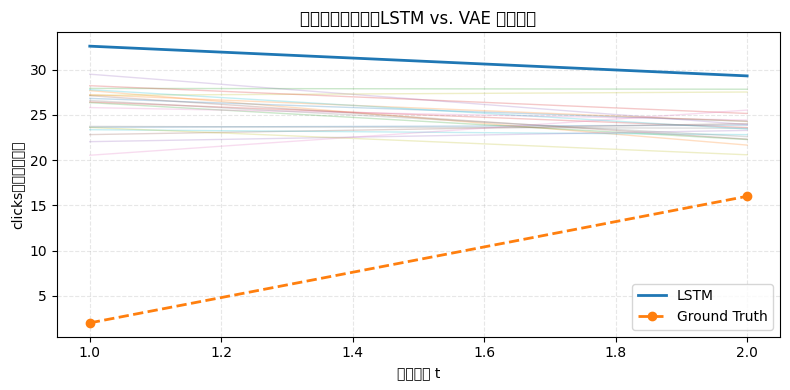


🎯 可視化樣本資訊（測試集隨機一筆）：
idx=15795, y_true=[2.0, 16.0], LSTM=[32.599998474121094, 29.309999465942383], VAE均值=[25.719999313354492, 23.850000381469727], VAE std=[2.3499999046325684, 1.7100000381469727]


In [2]:
# ============================================================
# OULAD：Seq2Seq LSTM 與 Seq2Seq VAE（Google Drive 版本，一鍵可跑）
# - 在 Google Colab 執行
# - 讀取 Google Drive 中的 OULAD CSV
# - 需求：studentInfo.csv / studentVle.csv / studentAssessment.csv
# - 功能：資料處理（每週序列）、學生ID切分、LSTM baseline、
#        VAE 多樣生成（Best-of-N、Diversity、Coverage）、視覺化
# ============================================================

# ==== 基本環境 ====
import os, math, random, warnings
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
warnings.filterwarnings("ignore")

# ==== 掛載 Google Drive ====
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

# ====> 修改這一行：把它換成你在雲端硬碟的實際資料夾
DATA_DIR = Path("/content/drive/MyDrive")

NEEDED = ["studentInfo.csv", "studentVle.csv", "studentAssessment.csv"]

# ==== 亂數種子 ====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ==== 超參數 ====
IN_WEEKS  = 4
OUT_WEEKS = 2
BATCH_SIZE = 128
EPOCHS = 5          # 規格：至少 5 epochs
LR = 1e-3
LATENT_DIM = 16
HIDDEN_DIM = 64
N_VAE_SAMPLES = 20  # VAE 生成樣本條數
BETA_KLD = 0.001    # VAE KL 權重（小一點穩定）

# ------------------------------------------------------------
# 安全讀檔（處理不同編碼）
# ------------------------------------------------------------
def safe_read_csv(path):
    for enc in ["utf-8", "utf-8-sig", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last = e
    raise last

# ------------------------------------------------------------
# 檢查 Drive 檔案是否存在
# ------------------------------------------------------------
missing = [f for f in NEEDED if not (DATA_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        f"在 Google Drive 資料夾 {DATA_DIR} 找不到：{missing}\n"
        f"請確認路徑與檔名（大小寫），或修改 DATA_DIR。"
    )
print("✅ 在 Drive 找到檔案：", [str((DATA_DIR/f)) for f in NEEDED])

# ------------------------------------------------------------
# 讀檔
# ------------------------------------------------------------
stu = safe_read_csv(DATA_DIR / "studentInfo.csv")
vle = safe_read_csv(DATA_DIR / "studentVle.csv")
asm = safe_read_csv(DATA_DIR / "studentAssessment.csv")
assessments = safe_read_csv(DATA_DIR / "assessments.csv") if (DATA_DIR/"assessments.csv").exists() else None

print("✅ 讀取成功：", len(stu), len(vle), len(asm))

# ------------------------------------------------------------
# 資料處理：以學生 ID 為單位建立「每週序列」
# 需求特徵：
#   clicks（每週點擊數）、submit_cnt/has_submit、avg_score_sofar（累積平均分）、clicks_diff1（點擊差分）
# ------------------------------------------------------------

# ---- 將 VLE 日期轉為 week_idx（以課程最早日為週0）----
vle["date"] = pd.to_numeric(vle["date"], errors="coerce")
vle = vle.dropna(subset=["date"])
vle["date"] = vle["date"].astype(int)

course_min_date = vle.groupby(["code_module","code_presentation"])["date"].min().rename("min_date")
vle = vle.merge(course_min_date, on=["code_module","code_presentation"], how="left")
vle["week_idx"] = ((vle["date"] - vle["min_date"]) // 7).astype(int)
vle = vle[vle["week_idx"] >= 0]

# ---- 每週點擊數 clicks ----
click_col = "sum_click" if "sum_click" in vle.columns else ("sum_clicks" if "sum_clicks" in vle.columns else ("click" if "click" in vle.columns else None))
if click_col is None:
    raise ValueError("studentVle.csv 找不到 sum_click / sum_clicks / click 欄位，請檢查檔案版本。")

week_clicks = (vle.groupby(["id_student","code_module","code_presentation","week_idx"])[click_col]
                 .sum()
                 .reset_index()
                 .rename(columns={click_col:"clicks"}))

# ---- 作業提交週與分數 ----
# 若 assessments.csv 存在可對齊更多 meta；沒有也能跑
asm["date_submitted"] = pd.to_numeric(asm.get("date_submitted", np.nan), errors="coerce")

# 確保 studentAssessment 具有 module / presentation
for col in ["code_module","code_presentation"]:
    if col not in asm.columns:
        asm[col] = np.nan

# 若缺 module/presentation：用該學生在 VLE 出現最多的課程期別補上（簡化可行）
if asm["code_module"].isna().any() or asm["code_presentation"].isna().any():
    top_course = (vle.groupby("id_student")[["code_module","code_presentation"]]
                    .agg(lambda s: s.value_counts().index[0])
                    .reset_index())
    asm = asm.drop(columns=[c for c in ["code_module","code_presentation"] if c in asm.columns], errors="ignore")
    asm = asm.merge(top_course, on="id_student", how="left")

asm = asm.merge(course_min_date.reset_index(), on=["code_module","code_presentation"], how="left")
asm = asm.dropna(subset=["date_submitted","min_date"])
asm["week_idx"] = ((asm["date_submitted"] - asm["min_date"]) // 7).astype(int)
asm = asm[asm["week_idx"] >= 0]

submit_week = (asm.groupby(["id_student","code_module","code_presentation","week_idx"])
                 .agg(submit_cnt=("id_assessment","count"),
                      score_sum=("score","sum"),
                      score_cnt=("score","count"))
                 .reset_index())
submit_week["has_submit"] = (submit_week["submit_cnt"] > 0).astype(int)

# ---- 建立每位學生在每個課程的完整週基底 ----
def build_student_week_frame(df_clicks):
    frames = []
    for (sid, mod, pres), g in df_clicks.groupby(["id_student","code_module","code_presentation"]):
        wmax = g["week_idx"].max()
        base = pd.DataFrame({
            "id_student":[sid]*(wmax+1),
            "code_module":[mod]*(wmax+1),
            "code_presentation":[pres]*(wmax+1),
            "week_idx": np.arange(0, wmax+1, dtype=int)
        })
        frames.append(base)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

base_weeks = build_student_week_frame(week_clicks)
if base_weeks.empty:
    raise RuntimeError("基底週表為空，請檢查 studentVle.csv 內容是否正確。")

feat = base_weeks.merge(week_clicks, on=["id_student","code_module","code_presentation","week_idx"], how="left")
feat = feat.merge(submit_week, on=["id_student","code_module","code_presentation","week_idx"], how="left")

feat["clicks"] = feat["clicks"].fillna(0.0)
feat["submit_cnt"] = feat["submit_cnt"].fillna(0).astype(int)
feat["has_submit"] = feat["has_submit"].fillna(0).astype(int)
feat["score_sum"] = feat["score_sum"].fillna(0.0)
feat["score_cnt"] = feat["score_cnt"].fillna(0.0)

# 累積平均分數（以學生-課程為單位）
feat["avg_score_sofar"] = 0.0
for (sid, mod, pres), g in feat.groupby(["id_student","code_module","code_presentation"], sort=False):
    idx = g.index
    cumsum = g["score_sum"].cumsum()
    cumcnt = g["score_cnt"].cumsum().replace(0, np.nan)
    avg = cumsum / cumcnt
    feat.loc[idx, "avg_score_sofar"] = avg.fillna(0.0).values

# 點擊數差分
feat["clicks_diff1"] = feat.groupby(["id_student","code_module","code_presentation"])["clicks"].diff().fillna(0.0)

# 保留欄位
feat = feat[["id_student","code_module","code_presentation","week_idx",
             "clicks","submit_cnt","has_submit","avg_score_sofar","clicks_diff1"]]

# ------------------------------------------------------------
# 以學生 ID 分割 train/valid/test（避免洩漏）
# ------------------------------------------------------------
all_students = feat["id_student"].unique()
rng = np.random.default_rng(SEED)
rng.shuffle(all_students)

n = len(all_students)
n_train = int(n*0.7)
n_valid = int(n*0.15)
train_ids = set(all_students[:n_train])
valid_ids = set(all_students[n_train:n_train+n_valid])
test_ids  = set(all_students[n_train+n_valid:])

def split_by_ids(df):
    tr = df[df["id_student"].isin(train_ids)].copy()
    va = df[df["id_student"].isin(valid_ids)].copy()
    te = df[df["id_student"].isin(test_ids)].copy()
    return tr, va, te

feat_tr, feat_va, feat_te = split_by_ids(feat)
print(f"✅ 切分完成：train/valid/test 學生數 = {len(train_ids)}/{len(valid_ids)}/{len(test_ids)}")

# ------------------------------------------------------------
# 組成 Seq2Seq 樣本（滑動視窗）
#   X: (IN_WEEKS, n_features)
#   y: (OUT_WEEKS,)    # 只預測未來 clicks
# ------------------------------------------------------------
FEATURES = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]

def make_sequences(df):
    Xs, ys, meta = [], [], []
    for (sid, mod, pres), g in df.groupby(["id_student","code_module","code_presentation"], sort=False):
        g = g.sort_values("week_idx").reset_index(drop=True)
        arrX = g[FEATURES].values.astype(np.float32)
        arrY = g["clicks"].values.astype(np.float32)
        T = len(g)
        for t in range(IN_WEEKS, T-OUT_WEEKS+1):
            x = arrX[t-IN_WEEKS:t]
            y = arrY[t:t+OUT_WEEKS]
            Xs.append(x)
            ys.append(y)
            meta.append((sid, mod, pres, int(g.loc[t-1,"week_idx"])))
    if len(Xs)==0:
        return np.zeros((0,IN_WEEKS,len(FEATURES)), dtype=np.float32), np.zeros((0,OUT_WEEKS), dtype=np.float32), []
    return np.stack(Xs), np.stack(ys), meta

X_tr, y_tr, meta_tr = make_sequences(feat_tr)
X_va, y_va, meta_va = make_sequences(feat_va)
X_te, y_te, meta_te = make_sequences(feat_te)

print("資料張數：", X_tr.shape, y_tr.shape, "|", X_va.shape, y_va.shape, "|", X_te.shape, y_te.shape)
if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
    raise RuntimeError("序列樣本不足，請檢查 CSV 是否為正確 OULAD。")

# ------------------------------------------------------------
# 特徵標準化（以訓練集統計）
# y（clicks）也標準化；評估/繪圖會反標準化
# ------------------------------------------------------------
X_mean = X_tr.reshape(-1, len(FEATURES)).mean(axis=0)
X_std  = X_tr.reshape(-1, len(FEATURES)).std(axis=0) + 1e-6
y_mean = y_tr.mean()
y_std  = y_tr.std() + 1e-6

def norm_X(X): return (X - X_mean) / X_std
def norm_y(y): return (y - y_mean) / y_std
def denorm_y(yhat): return yhat * y_std + y_mean

X_tr_n = norm_X(X_tr); X_va_n = norm_X(X_va); X_te_n = norm_X(X_te)
y_tr_n = norm_y(y_tr); y_va_n = norm_y(y_va); y_te_n = norm_y(y_te)

# ------------------------------------------------------------
# PyTorch 模型
# ------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ 使用裝置：", device)

train_loader = DataLoader(TensorDataset(torch.tensor(X_tr_n), torch.tensor(y_tr_n)),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_va_n), torch.tensor(y_va_n)),
                          batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_te_n), torch.tensor(y_te_n)),
                          batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ---- Seq2Seq LSTM ----
class Seq2SeqLSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_weeks=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.GRU(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)
        self.out_weeks = out_weeks

    def forward(self, x):
        _, (h, c) = self.encoder(x)     # h: (1,B,H)
        B = x.size(0)
        dec_in = torch.zeros(B, 1, 1, device=x.device)
        h_dec = h                        # (1,B,H)
        preds = []
        for _ in range(self.out_weeks):
            out_t, h_dec = self.decoder(dec_in, h_dec)
            y_t = self.out(out_t)        # (B,1,1)
            preds.append(y_t)
            dec_in = y_t.detach()
        y_pred = torch.cat(preds, dim=1).squeeze(-1)  # (B, OUT_WEEKS)
        return y_pred

# ---- Seq2Seq VAE ----
class Seq2SeqVAE(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_weeks=2, latent_dim=16):
        super().__init__()
        self.enc = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, batch_first=True)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)
        self.dec_init = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.GRU(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)
        self.out_weeks = out_weeks

    def encode(self, x):
        _, (h, c) = self.enc(x)
        h_last = h.squeeze(0)            # (B,H)
        mu = self.mu(h_last)             # (B,Z)
        logvar = self.logvar(h_last)     # (B,Z)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_from_z(self, z):
        h0 = torch.tanh(self.dec_init(z)).unsqueeze(0)  # (1,B,H)
        B = z.size(0)
        dec_in = torch.zeros(B, 1, 1, device=z.device)
        preds = []
        h_dec = h0
        for _ in range(self.out_weeks):
            out_t, h_dec = self.decoder(dec_in, h_dec)
            y_t = self.out(out_t)
            preds.append(y_t)
            dec_in = y_t.detach()
        return torch.cat(preds, dim=1).squeeze(-1)  # (B, OUT_WEEKS)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        y = self.decode_from_z(z)
        return y, mu, logvar

# ------------------------------------------------------------
# 訓練與評估工具
# ------------------------------------------------------------
def train_lstm(model, train_loader, valid_loader, epochs=5, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(1, epochs+1):
        model.train(); tr_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device).float(); yb = yb.to(device).float()
            opt.zero_grad(); yhat = model(xb)
            loss = loss_fn(yhat, yb); loss.backward(); opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(train_loader.dataset)

        model.eval(); va_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb = xb.to(device).float(); yb = yb.to(device).float()
                yhat = model(xb); va_loss += loss_fn(yhat, yb).item() * xb.size(0)
        va_loss /= len(valid_loader.dataset)
        print(f"[LSTM] Epoch {ep}/{epochs} | train MSE={tr_loss:.4f} | valid MSE={va_loss:.4f}")
    return model

def kld_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def train_vae(model, train_loader, valid_loader, epochs=5, lr=1e-3, beta=BETA_KLD):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    rec_loss_fn = nn.MSELoss()
    for ep in range(1, epochs+1):
        model.train(); tr_rec, tr_kld = 0.0, 0.0
        for xb, yb in train_loader:
            xb = xb.to(device).float(); yb = yb.to(device).float()
            opt.zero_grad()
            yhat, mu, logvar = model(xb)
            rec = rec_loss_fn(yhat, yb)
            kld = kld_loss(mu, logvar)
            (rec + beta * kld).backward(); opt.step()
            tr_rec += rec.item() * xb.size(0); tr_kld += kld.item() * xb.size(0)
        tr_rec /= len(train_loader.dataset); tr_kld /= len(train_loader.dataset)

        model.eval(); va_rec = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb = xb.to(device).float(); yb = yb.to(device).float()
                yhat, mu, logvar = model(xb)
                va_rec += rec_loss_fn(yhat, yb).item() * xb.size(0)
        va_rec /= len(valid_loader.dataset)
        print(f"[VAE ] Epoch {ep}/{epochs} | train REC={tr_rec:.4f} KLD={tr_kld:.4f} | valid REC={va_rec:.4f}")
    return model

def mse(a, b): return np.mean((a - b)**2)

# ------------------------------------------------------------
# 建立與訓練模型
# ------------------------------------------------------------
in_dim = len(FEATURES)
lstm = Seq2SeqLSTM(in_dim=in_dim, hidden_dim=HIDDEN_DIM, out_weeks=OUT_WEEKS)
lstm = train_lstm(lstm, train_loader, valid_loader, epochs=EPOCHS, lr=LR)

vae = Seq2SeqVAE(in_dim=in_dim, hidden_dim=HIDDEN_DIM, out_weeks=OUT_WEEKS, latent_dim=LATENT_DIM)
vae = train_vae(vae, train_loader, valid_loader, epochs=EPOCHS, lr=LR, beta=BETA_KLD)

# ------------------------------------------------------------
# 評估：LSTM 單一路徑、VAE Best-of-N / Diversity / Coverage
# ------------------------------------------------------------
lstm.eval(); vae.eval()

all_y_true, all_lstm_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float(); yb = yb.to(device).float()
        yh = lstm(xb)
        all_y_true.append(yb.cpu().numpy()); all_lstm_pred.append(yh.cpu().numpy())

y_true_n = np.concatenate(all_y_true, axis=0)
y_lstm_n = np.concatenate(all_lstm_pred, axis=0)
y_true = denorm_y(y_true_n); y_lstm = denorm_y(y_lstm_n)

lstm_total_mse = mse(y_true, y_lstm)
lstm_seq_mses = np.mean((y_true - y_lstm)**2, axis=1)
lstm_median_mse = float(np.median(lstm_seq_mses))

vae_best_mses, vae_diversities = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float(); yb = yb.to(device).float()
        samples = []
        for _ in range(N_VAE_SAMPLES):
            yk, _, _ = vae(xb)
            samples.append(yk.cpu().numpy())
        samples = np.stack(samples, axis=0)                 # (N,B,OUT_WEEKS)
        samples_denorm = denorm_y(samples)                  # 反標準化
        y_true_batch = denorm_y(yb.cpu().numpy())

        mses_per_k = np.mean((samples_denorm - y_true_batch[None, :, :])**2, axis=2)  # (N,B)
        best_per_seq = mses_per_k.min(axis=0)               # (B,)
        vae_best_mses.extend(best_per_seq.tolist())

        std_per_t = samples_denorm.std(axis=0)              # (B, OUT_WEEKS)
        vae_diversities.extend(std_per_t.mean(axis=1).tolist())

tau = lstm_median_mse
coverage = float(np.mean(np.array(vae_best_mses) < tau))
global_diversity = float(np.mean(vae_diversities))
best_of_n_mse = float(np.mean(vae_best_mses))

print("\n========== 評估結果（原始尺度） ==========")
print(f"LSTM   MSE（整體）        : {lstm_total_mse:.4f}")
print(f"VAE    Best-of-N MSE     : {best_of_n_mse:.4f}  （N={N_VAE_SAMPLES}）")
print(f"VAE    Diversity（std）   : {global_diversity:.4f}")
print(f"VAE    Coverage（比例）   : {coverage:.4f}   （門檻 tau = LSTM 每序列 MSE 中位數 = {tau:.4f}）")

# ------------------------------------------------------------
# 視覺化：選擇一位測試樣本，顯示 GT / LSTM / VAE 多樣本
# ------------------------------------------------------------
import matplotlib.pyplot as plt

idx_global = np.random.randint(0, y_te.shape[0])
xb = torch.tensor(X_te_n[idx_global:idx_global+1]).to(device).float()
with torch.no_grad():
    y_lstm_case = lstm(xb).cpu().numpy()[0]
    y_lstm_case = denorm_y(y_lstm_case)
    vae_samples = []
    for _ in range(N_VAE_SAMPLES):
        yk, _, _ = vae(xb)
        vae_samples.append(denorm_y(yk.cpu().numpy()[0]))
    vae_samples = np.stack(vae_samples, axis=0)

y_true_case = y_te[idx_global]
t = np.arange(1, OUT_WEEKS+1)

plt.figure(figsize=(8,4))
for k in range(min(N_VAE_SAMPLES, 30)):
    plt.plot(t, vae_samples[k], alpha=0.25, linewidth=1, label="_nolegend_")
plt.plot(t, y_lstm_case, linewidth=2, label="LSTM")
plt.plot(t, y_true_case, linewidth=2, linestyle="--", marker="o", label="Ground Truth")
plt.title("未來點擊數預測：LSTM vs. VAE 多樣生成")
plt.xlabel("未來週次 t"); plt.ylabel("clicks（原始尺度）")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout(); plt.show()

print("\n🎯 可視化樣本資訊（測試集隨機一筆）：")
print(f"idx={idx_global}, y_true={np.round(y_true_case,2).tolist()}, "
      f"LSTM={np.round(y_lstm_case,2).tolist()}, "
      f"VAE均值={np.round(vae_samples.mean(axis=0),2).tolist()}, "
      f"VAE std={np.round(vae_samples.std(axis=0),2).tolist()}")


In [3]:
# ================= 數字化評估面板 =================
import numpy as np, pandas as pd, torch, math
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 先重算「每個樣本」的 LSTM 預測、VAE 多樣本（為了拿到 best 的逐步預測）
all_y_true, all_lstm, all_best_vae, all_div_seq = [], [], [], []
all_lstm_mse, all_best_mse = [], []
all_step_mse_lstm, all_step_mse_vae = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).float()            # 標準化空間
        # LSTM
        y_l = lstm(xb).cpu().numpy()          # (B, OUT_WEEKS) 標準化
        # VAE N條樣本
        samples = []
        for _ in range(N_VAE_SAMPLES):
            yk, _, _ = vae(xb)
            samples.append(yk.cpu().numpy())
        samples = np.stack(samples, axis=0)   # (N,B,OUT_WEEKS)

        # 反標準化
        y_true = denorm_y(yb.cpu().numpy())
        y_l = denorm_y(y_l)
        y_s = denorm_y(samples)               # (N,B,OUT_WEEKS)

        # 找每個序列的 best-of-N
        # mse_kb: (N,B)
        mse_kb = np.mean((y_s - y_true[None,:,:])**2, axis=2)
        best_idx = np.argmin(mse_kb, axis=0)                 # (B,)
        best_pred = y_s[best_idx, np.arange(y_s.shape[1])]   # (B, OUT_WEEKS)
        best_mse = np.mean((best_pred - y_true)**2, axis=1)  # (B,)

        # Diversity：每序列樣本在每個步長的 std 再平均
        div_seq = y_s.std(axis=0).mean(axis=1)               # (B,)

        # 每一步的MSE（方便看 t=1/t=2）
        step_mse_l = np.mean((y_l - y_true)**2, axis=0)      # (OUT_WEEKS,)
        step_mse_v = np.mean((best_pred - y_true)**2, axis=0)

        # 收集
        all_y_true.append(y_true)
        all_lstm.append(y_l)
        all_best_vae.append(best_pred)
        all_div_seq.append(div_seq)
        all_lstm_mse.append(np.mean((y_l - y_true)**2, axis=1))
        all_best_mse.append(best_mse)
        all_step_mse_lstm.append(step_mse_l)
        all_step_mse_vae.append(step_mse_v)

# 拼接
Y_TRUE = np.vstack(all_y_true)
Y_LSTM = np.vstack(all_lstm)
Y_VAEB = np.vstack(all_best_vae)   # VAE best-of-N 的逐步預測
DIV_SEQ = np.concatenate(all_div_seq)
MSE_LSTM_SEQ = np.concatenate(all_lstm_mse)
MSE_VAEB_SEQ = np.concatenate(all_best_mse)
STEP_MSE_LSTM = np.vstack(all_step_mse_lstm).mean(axis=0)  # (OUT_WEEKS,)
STEP_MSE_VAEB = np.vstack(all_step_mse_vae).mean(axis=0)

# ===== 1) 整體指標總表 =====
improve_abs = MSE_LSTM_SEQ.mean() - MSE_VAEB_SEQ.mean()
improve_pct = 100.0 * improve_abs / (MSE_LSTM_SEQ.mean() + 1e-9)
coverage_tau = float(np.median(MSE_LSTM_SEQ))
coverage = float(np.mean(MSE_VAEB_SEQ < coverage_tau))

summary = pd.DataFrame({
    "Metric": ["LSTM MSE (mean)", "VAE Best-of-N MSE (mean)", "Improvement (abs)", "Improvement (%)",
               "Coverage (VAE best < LSTM median MSE)", "Diversity (std per seq, mean)", "Diversity (std per seq, median)"],
    "Value":  [MSE_LSTM_SEQ.mean(), MSE_VAEB_SEQ.mean(), improve_abs, improve_pct,
               coverage, float(DIV_SEQ.mean()), float(np.median(DIV_SEQ))]
})
print("\n=== Overall Summary ===")
display(summary)

# ===== 2) 分位數表 =====
def qts(a):
    return pd.Series({
        "P10": np.quantile(a, 0.10),
        "P25": np.quantile(a, 0.25),
        "P50": np.quantile(a, 0.50),
        "P75": np.quantile(a, 0.75),
        "P90": np.quantile(a, 0.90),
        "Mean": a.mean()
    })
dist_table = pd.concat({
    "LSTM per-seq MSE": qts(MSE_LSTM_SEQ),
    "VAE best per-seq MSE": qts(MSE_VAEB_SEQ),
    "Diversity (std)": qts(DIV_SEQ)
}, axis=1)
print("\n=== Distribution (per sequence) ===")
display(dist_table)

# ===== 3) 勝率分組表（VAE 比 LSTM 好多少）=====
delta = MSE_LSTM_SEQ - MSE_VAEB_SEQ  # >0 表示 VAE 較佳
bins = [-math.inf, -1000, -200, -50, -10, 0, 10, 50, 200, 1000, math.inf]
labels = ["VAE<<劣(>1000)", "VAE劣(200~1000)", "VAE劣(50~200)", "VAE劣(10~50)", "VAE略劣(<10)",
          "≈打平(±10)", "VAE略勝(10~50)", "VAE勝(50~200)", "VAE大勝(200~1000)", "VAE>>大勝(>1000)"]
bucket = pd.cut(delta, bins=bins, labels=labels, right=False)
win_table = bucket.value_counts().rename_axis("Improvement bucket").reset_index(name="count")
win_table["ratio"] = (win_table["count"] / len(delta)).round(4)
print("\n=== Win-rate by improvement bucket (Δ = LSTM MSE − VAE best MSE) ===")
display(win_table.sort_values("Improvement bucket"))

# ===== 4) 每一步 MSE（t=1, t=2 ...）=====
step_df = pd.DataFrame({
    "horizon": [f"t={i+1}" for i in range(OUT_WEEKS)],
    "LSTM_step_MSE": STEP_MSE_LSTM,
    "VAE_best_step_MSE": STEP_MSE_VAEB
})
print("\n=== Per-step MSE ===")
display(step_df)

# ===== 5) Top-5 改善 / 退步樣本 =====
improve_each = delta  # 同上
idx_sorted_best = np.argsort(-improve_each)[:5]  # 最大改善
idx_sorted_worst = np.argsort(improve_each)[:5]  # 最嚴重退步

def summarize_rows(indices):
    rows = []
    for i in indices:
        rows.append({
            "idx": int(i),
            "LSTM_MSE": float(MSE_LSTM_SEQ[i]),
            "VAE_best_MSE": float(MSE_VAEB_SEQ[i]),
            "Δ(LSTM−VAE)": float(improve_each[i]),
            "y_true": np.round(Y_TRUE[i], 2).tolist(),
            "y_LSTM": np.round(Y_LSTM[i], 2).tolist(),
            "y_VAE_best": np.round(Y_VAEB[i], 2).tolist(),
            "Diversity_std": float(DIV_SEQ[i])
        })
    return pd.DataFrame(rows)

print("\n=== Top-5 Improved (VAE best << LSTM) ===")
display(summarize_rows(idx_sorted_best))

print("\n=== Top-5 Regressed (VAE best >> LSTM) ===")
display(summarize_rows(idx_sorted_worst))



=== Overall Summary ===


,Metric,Value
0,LSTM MSE (mean),6013.323730
1,VAE Best-of-N MSE (mean),5693.025391
2,Improvement (abs),320.298340
3,Improvement (%),5.326478
4,Coverage (VAE best < LSTM median MSE),0.571060
5,"Diversity (std per seq, mean)",2.194876
6,"Diversity (std per seq, median)",2.025410



=== Distribution (per sequence) ===


,LSTM per-seq MSE,VAE best per-seq MSE,Diversity (std)
P10,132.840958,44.988289,1.577844
P25,319.168274,143.228546,1.762531
P50,799.491333,546.251709,2.025410
P75,2613.042969,2229.200684,2.426776
P90,8208.856445,7711.632812,2.962383
Mean,6013.323730,5693.025391,2.194876



=== Win-rate by improvement bucket (Δ = LSTM MSE − VAE best MSE) ===


,Improvement bucket,count,ratio
0,VAE<<劣(>1000),1664,0.0163
1,VAE劣(200~1000),5268,0.0516
2,VAE劣(50~200),5906,0.0579
3,VAE劣(10~50),3699,0.0363
4,VAE略劣(<10),1413,0.0139
5,≈打平(±10),1610,0.0158
6,VAE略勝(10~50),6471,0.0634
7,VAE勝(50~200),27443,0.2690
8,VAE大勝(200~1000),41637,0.4081
9,VAE>>大勝(>1000),6908,0.0677



=== Per-step MSE ===


,horizon,LSTM_step_MSE,VAE_best_step_MSE
0,t=1,5773.867188,5421.889160
1,t=2,6239.446777,5951.600098



=== Top-5 Improved (VAE best << LSTM) ===


,idx,LSTM_MSE,VAE_best_MSE,Δ(LSTM−VAE),y_true,y_LSTM,y_VAE_best,Diversity_std
0,62421,4481386.50,3997000.50,484386.00,"[2763.0, 2173.0]","[435.3599853515625, 290.2200012207031]","[535.1900024414062, 432.05999755859375]",14.211180
1,62420,5237357.00,4845568.00,391789.00,"[1770.0, 2763.0]","[16.15999984741211, 42.93000030517578]","[121.04000091552734, 122.52999877929688]",8.383551
2,94304,2456820.00,2245274.00,211546.00,"[2463.0, 1047.0]","[385.17999267578125, 274.7900085449219]","[460.2200012207031, 354.6000061035156]",9.573074
3,94303,2623592.25,2442303.25,181289.00,"[702.0, 2463.0]","[327.0299987792969, 203.22000122070312]","[390.4599914550781, 274.95001220703125]",13.209076
4,62417,1241138.75,1111398.00,129740.75,"[1114.0, 1219.0]","[43.33000183105469, 63.16999816894531]","[110.8499984741211, 116.05999755859375]",5.784474



=== Top-5 Regressed (VAE best >> LSTM) ===


,idx,LSTM_MSE,VAE_best_MSE,Δ(LSTM−VAE),y_true,y_LSTM,y_VAE_best,Diversity_std
0,99131,235691.12500,327980.906250,-92289.781250,"[6.0, 14.0]","[541.3900146484375, 443.80999755859375]","[625.1199951171875, 536.1599731445312]",5.338537
1,53464,152923.15625,227198.812500,-74275.656250,"[166.0, 10.0]","[536.1699829101562, 420.8800048828125]","[608.0, 518.9500122070312]",4.951410
2,67577,45823.25000,112729.492188,-66906.242188,"[184.0, 82.0]","[390.5899963378906, 303.2799987792969]","[516.739990234375, 420.739990234375]",6.347383
3,41410,56510.03125,118132.226562,-61622.195312,"[40.0, 290.0]","[376.0899963378906, 298.1499938964844]","[508.32000732421875, 420.1499938964844]",6.406301
4,34602,68766.25000,123464.718750,-54698.468750,"[127.0, 94.0]","[409.6700134277344, 334.07000732421875]","[504.6199951171875, 417.0]",4.754365


In [ ]:
# ------------------------------------------------------------
# 資料處理（以學生 ID 為單位建立「每週序列」）
# 需求特徵：
#   - 每週點擊數（clicks）
#   - 是否提交作業（submit_cnt / has_submit）
#   - 作業分數的累積平均（avg_score_sofar）
#   - 點擊數差分（clicks_diff1）
# 切分：以學生 ID 分割 train/valid/test（避免洩漏）
# ------------------------------------------------------------

# 1) 將每個 (code_module, code_presentation) 的日期對齊為週索引
# studentVle 中 date 是「課程起點的相對天數」。我們把同一課程/期別的最小 date 當週0起點。
vle["date"] = pd.to_numeric(vle["date"], errors="coerce")
vle = vle.dropna(subset=["date"])
vle["date"] = vle["date"].astype(int)

# 找每個課程開課最早日
course_min_date = vle.groupby(["code_module","code_presentation"])["date"].min().rename("min_date")
vle = vle.merge(course_min_date, on=["code_module","code_presentation"], how="left")
vle["week_idx"] = ((vle["date"] - vle["min_date"]) // 7).astype(int)
vle = vle[vle["week_idx"] >= 0]  # 去掉負週

# 2) 每週點擊數（sum of sum_click）
# studentVle 有 sum_click 與 sum_clicks（不同版本字段），統一處理
click_col = "sum_click" if "sum_click" in vle.columns else "sum_clicks"
if click_col not in vle.columns:
    # 有些釋出版本用 "click" 字段，保險處理
    if "click" in vle.columns:
        click_col = "click"
    else:
        raise ValueError("studentVle.csv 找不到 sum_click/sum_clicks/click 欄位，請檢查檔案版本。")

week_clicks = (vle.groupby(["id_student","code_module","code_presentation","week_idx"])[click_col]
                 .sum()
                 .reset_index()
                 .rename(columns={click_col:"clicks"}))

# 3) 從 studentAssessment 看提交紀錄與成績
#   - studentAssessment 通常有 date_submitted（相對天數）、score（得分），id_student、id_assessment。
#   - 需對齊到 (module, presentation)，把提交日轉成 week_idx。
# 合併 assessment 的 meta（模組、期別、截止日）
ass_meta_cols = ["id_assessment","code_module","code_presentation","date"]
ass_meta = pd.read_csv("assessments.csv") if os.path.exists("assessments.csv") else None
if ass_meta is None:
    # 某些 OULAD 發佈包不單獨提供 assessments.csv，而是包含在 studentAssessment 以共同 id 對到外部表。
    # 若沒有 assessments.csv，退而求其次：用 studentAssessment 的 (module, presentation) 與 studentVle 的 min_date 推週。
    # studentAssessment 裡通常也含有 code_module / code_presentation（某些版本有），若沒有則放空（後續用學生在 VLE 出現過的課程推斷）
    pass

# 嘗試從 studentAssessment 直接取得 module/presentation，若不存在就透過學生出現在 VLE 的課程推斷
for col in ["code_module","code_presentation"]:
    if col not in asm.columns:
        asm[col] = np.nan

# 將 date_submitted → week_idx（利用對應課程的 min_date）
asm["date_submitted"] = pd.to_numeric(asm.get("date_submitted", np.nan), errors="coerce")
asm.loc[asm["date_submitted"].isna(), "date_submitted"] = np.nan

# 若 asm 缺 module/presentation，嘗試從該學生在 VLE 最常見的課程期別補上（粗略但可運作）
if asm["code_module"].isna().any() or asm["code_presentation"].isna().any():
    # 找每個學生在 VLE 的 (module,presentation) 眾數
    top_course = (vle.groupby("id_student")[["code_module","code_presentation"]]
                    .agg(lambda s: s.value_counts().index[0])
                    .reset_index())
    asm = asm.drop(columns=[c for c in ["code_module","code_presentation"] if c in asm.columns], errors="ignore")
    asm = asm.merge(top_course, on="id_student", how="left")

# 連上 min_date 取得週
asm = asm.merge(course_min_date.reset_index(), on=["code_module","code_presentation"], how="left")
asm["week_idx"] = ((asm["date_submitted"] - asm["min_date"]) // 7).astype("Int64")
asm = asm.dropna(subset=["week_idx"])
asm["week_idx"] = asm["week_idx"].astype(int)
asm = asm[asm["week_idx"] >= 0]

# 4) 每週提交次數 submit_cnt 與 has_submit
submit_week = (asm.groupby(["id_student","code_module","code_presentation","week_idx"])
                 .agg(submit_cnt=("id_assessment","count"),
                      score_sum=("score","sum"),
                      score_cnt=("score","count"))
                 .reset_index())
submit_week["has_submit"] = (submit_week["submit_cnt"] > 0).astype(int)

# 5) 作業分數「累積平均」avg_score_sofar
#   先建立每位學生每週的基底週表，再做 left-join、最後用 expanding 平均
def build_student_week_frame(df_clicks):
    # 擷取每個 (student, course) 的週範圍
    frames = []
    for (sid, mod, pres), g in df_clicks.groupby(["id_student","code_module","code_presentation"]):
        wmax = g["week_idx"].max()
        base = pd.DataFrame({
            "id_student":[sid]*(wmax+1),
            "code_module":[mod]*(wmax+1),
            "code_presentation":[pres]*(wmax+1),
            "week_idx": np.arange(0, wmax+1, dtype=int)
        })
        frames.append(base)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

base_weeks = build_student_week_frame(week_clicks)
if base_weeks.empty:
    raise RuntimeError("基底週表為空，請檢查 studentVle.csv 內容是否正確。")

feat = base_weeks.merge(week_clicks, on=["id_student","code_module","code_presentation","week_idx"], how="left")
feat = feat.merge(submit_week, on=["id_student","code_module","code_presentation","week_idx"], how="left")

feat["clicks"] = feat["clicks"].fillna(0.0)
feat["submit_cnt"] = feat["submit_cnt"].fillna(0).astype(int)
feat["has_submit"] = feat["has_submit"].fillna(0).astype(int)
feat["score_sum"] = feat["score_sum"].fillna(0.0)
feat["score_cnt"] = feat["score_cnt"].fillna(0.0)

# 依學生-課程累積平均分數
feat["avg_score_sofar"] = 0.0
for (sid, mod, pres), g in feat.groupby(["id_student","code_module","code_presentation"], sort=False):
    idx = g.index
    cumsum = g["score_sum"].cumsum()
    cumcnt = g["score_cnt"].cumsum().replace(0, np.nan)
    avg = cumsum / cumcnt
    feat.loc[idx, "avg_score_sofar"] = avg.fillna(0.0).values

# 點擊數差分
feat["clicks_diff1"] = feat.groupby(["id_student","code_module","code_presentation"])["clicks"].diff().fillna(0.0)

# 只保留需要的欄位
feat = feat[["id_student","code_module","code_presentation","week_idx",
             "clicks","submit_cnt","has_submit","avg_score_sofar","clicks_diff1"]]

# ------------------------------------------------------------
# 以學生 ID 做資料切分（避免洩漏）
# ------------------------------------------------------------
all_students = feat["id_student"].unique()
rng = np.random.default_rng(SEED)
rng.shuffle(all_students)

n = len(all_students)
n_train = int(n*0.7)
n_valid = int(n*0.15)
train_ids = set(all_students[:n_train])
valid_ids = set(all_students[n_train:n_train+n_valid])
test_ids  = set(all_students[n_train+n_valid:])

def split_by_ids(df):
    tr = df[df["id_student"].isin(train_ids)].copy()
    va = df[df["id_student"].isin(valid_ids)].copy()
    te = df[df["id_student"].isin(test_ids)].copy()
    return tr, va, te

feat_tr, feat_va, feat_te = split_by_ids(feat)
print(f"✅ 切分完成：train/valid/test 學生數 = {len(train_ids)}/{len(valid_ids)}/{len(test_ids)}")

# ------------------------------------------------------------
# 組成 Seq2Seq 樣本（滑動視窗）
#   X: (IN_WEEKS, n_features)
#   y: (OUT_WEEKS,)    # 只預測未來 clicks
# ------------------------------------------------------------
FEATURES = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]

def make_sequences(df):
    Xs, ys, meta = [], [], []
    # 依每個 (student, course) 各自滑動
    for (sid, mod, pres), g in df.groupby(["id_student","code_module","code_presentation"], sort=False):
        g = g.sort_values("week_idx").reset_index(drop=True)
        arrX = g[FEATURES].values.astype(np.float32)
        arrY = g["clicks"].values.astype(np.float32)
        T = len(g)
        for t in range(IN_WEEKS, T-OUT_WEEKS+1):
            x = arrX[t-IN_WEEKS:t]                     # (IN_WEEKS, F)
            y = arrY[t:t+OUT_WEEKS]                   # (OUT_WEEKS,)
            Xs.append(x)
            ys.append(y)
            meta.append((sid, mod, pres, int(g.loc[t-1,"week_idx"])))  # 記錄當下對應週
    if len(Xs)==0:
        return np.zeros((0,IN_WEEKS,len(FEATURES)), dtype=np.float32), np.zeros((0,OUT_WEEKS), dtype=np.float32), []
    return np.stack(Xs), np.stack(ys), meta

X_tr, y_tr, meta_tr = make_sequences(feat_tr)
X_va, y_va, meta_va = make_sequences(feat_va)
X_te, y_te, meta_te = make_sequences(feat_te)

print("資料張數：", X_tr.shape, y_tr.shape, "|", X_va.shape, y_va.shape, "|", X_te.shape, y_te.shape)
if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
    raise RuntimeError("序列樣本不足，請確認檔案是否為 OULAD 正確版本。")

# ------------------------------------------------------------
# 特徵標準化（以訓練集統計）
#   注意：y（clicks）也做標準化以穩定訓練，但最後評估與繪圖會反標準化回原尺度
# ------------------------------------------------------------
X_mean = X_tr.reshape(-1, len(FEATURES)).mean(axis=0)
X_std  = X_tr.reshape(-1, len(FEATURES)).std(axis=0) + 1e-6

y_mean = y_tr.mean()
y_std  = y_tr.std() + 1e-6

def norm_X(X):
    return (X - X_mean) / X_std

def norm_y(y):
    return (y - y_mean) / y_std

def denorm_y(yhat):
    return yhat * y_std + y_mean

X_tr_n = norm_X(X_tr)
X_va_n = norm_X(X_va)
X_te_n = norm_X(X_te)
y_tr_n = norm_y(y_tr)
y_va_n = norm_y(y_va)
y_te_n = norm_y(y_te)

# ------------------------------------------------------------
# PyTorch 模型
# ------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ 使用裝置：", device)

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_tr_n), torch.tensor(y_tr_n)),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
valid_loader = DataLoader(
    TensorDataset(torch.tensor(X_va_n), torch.tensor(y_va_n)),
    batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)
test_tensor = TensorDataset(torch.tensor(X_te_n), torch.tensor(y_te_n))
test_loader = DataLoader(test_tensor, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ---- Seq2Seq LSTM Baseline ----
class Seq2SeqLSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_weeks=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, batch_first=True)
        # 用最後隱狀態逐步解碼產生 OUT_WEEKS
        self.decoder = nn.GRU(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)
        self.out_weeks = out_weeks

    def forward(self, x):
        # x: (B, IN_WEEKS, F)
        _, (h, c) = self.encoder(x)   # h: (1,B,H)
        h0 = h.transpose(0,1)         # (B,1,H)
        # 解碼：以「零起點」遞迴，簡化
        B = x.size(0)
        dec_in = torch.zeros(B, 1, 1, device=x.device)  # 第一個步的輸入（老師強迫為0）
        h_dec = h.transpose(0,1)  # (B,1,H) -> 作為 GRU 的隱狀態
        preds = []
        for t in range(self.out_weeks):
            out_t, h_dec_t = self.decoder(dec_in, h_dec.transpose(0,1))
            y_t = self.out(out_t)  # (B,1,1)
            preds.append(y_t)
            dec_in = y_t.detach()  # 下一步用自己的輸出（不 teacher forcing 以保持簡單）
            h_dec = h_dec_t.transpose(0,1)
        y_pred = torch.cat(preds, dim=1).squeeze(-1)  # (B, OUT_WEEKS)
        return y_pred

# ---- Seq2Seq VAE（在 LSTM encoder 上加 latent z）----
class Seq2SeqVAE(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_weeks=2, latent_dim=16):
        super().__init__()
        self.enc = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, batch_first=True)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        self.dec_init = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.GRU(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)
        self.out_weeks = out_weeks
        self.latent_dim = latent_dim

    def encode(self, x):
        _, (h, c) = self.enc(x)             # h: (1,B,H)
        h_last = h.squeeze(0)               # (B,H)
        mu = self.mu(h_last)                # (B,Z)
        logvar = self.logvar(h_last)        # (B,Z)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_from_z(self, z):
        # 用 z 初始化 decoder 隱狀態，逐步產生 OUT_WEEKS
        h0 = torch.tanh(self.dec_init(z)).unsqueeze(0)  # (1,B,H)
        B = z.size(0)
        dec_in = torch.zeros(B, 1, 1, device=z.device)
        preds = []
        h_dec = h0
        for t in range(self.out_weeks):
            out_t, h_dec = self.decoder(dec_in, h_dec)
            y_t = self.out(out_t)  # (B,1,1)
            preds.append(y_t)
            dec_in = y_t.detach()
        y = torch.cat(preds, dim=1).squeeze(-1)  # (B,OUT_WEEKS)
        return y

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        y = self.decode_from_z(z)
        return y, mu, logvar

# ------------------------------------------------------------
# 訓練與評估工具
# ------------------------------------------------------------
def train_lstm(model, train_loader, valid_loader, epochs=5, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(1, epochs+1):
        model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(train_loader.dataset)

        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb = xb.to(device).float()
                yb = yb.to(device).float()
                yhat = model(xb)
                loss = loss_fn(yhat, yb)
                va_loss += loss.item() * xb.size(0)
        va_loss /= len(valid_loader.dataset)
        print(f"[LSTM] Epoch {ep}/{epochs} | train MSE={tr_loss:.4f} | valid MSE={va_loss:.4f}")
    return model

def kld_loss(mu, logvar):
    # KL(N(mu, sigma) || N(0, I)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def train_vae(model, train_loader, valid_loader, epochs=5, lr=1e-3, beta=BETA_KLD):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    rec_loss_fn = nn.MSELoss()
    for ep in range(1, epochs+1):
        model.train()
        tr_rec, tr_kld = 0.0, 0.0
        for xb, yb in train_loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            opt.zero_grad()
            yhat, mu, logvar = model(xb)
            rec = rec_loss_fn(yhat, yb)
            kld = kld_loss(mu, logvar)
            loss = rec + beta * kld
            loss.backward()
            opt.step()
            tr_rec += rec.item() * xb.size(0)
            tr_kld += kld.item() * xb.size(0)
        tr_rec /= len(train_loader.dataset)
        tr_kld /= len(train_loader.dataset)

        # valid
        model.eval()
        va_rec = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb = xb.to(device).float()
                yb = yb.to(device).float()
                yhat, mu, logvar = model(xb)
                rec = rec_loss_fn(yhat, yb)
                va_rec += rec.item() * xb.size(0)
        va_rec /= len(valid_loader.dataset)
        print(f"[VAE ] Epoch {ep}/{epochs} | train REC={tr_rec:.4f} KLD={tr_kld:.4f} | valid REC={va_rec:.4f}")
    return model

def mse(a, b):
    return np.mean((a - b)**2)

# ------------------------------------------------------------
# 建立與訓練模型
# ------------------------------------------------------------
in_dim = len(FEATURES)

lstm = Seq2SeqLSTM(in_dim=in_dim, hidden_dim=HIDDEN_DIM, out_weeks=OUT_WEEKS)
lstm = train_lstm(lstm, train_loader, valid_loader, epochs=EPOCHS, lr=LR)

vae = Seq2SeqVAE(in_dim=in_dim, hidden_dim=HIDDEN_DIM, out_weeks=OUT_WEEKS, latent_dim=LATENT_DIM)
vae = train_vae(vae, train_loader, valid_loader, epochs=EPOCHS, lr=LR, beta=BETA_KLD)

# ------------------------------------------------------------
# 評估
# - LSTM：單一路徑 MSE
# - VAE：Best-of-N MSE、Diversity（樣本間 std）、Coverage（至少一條接近真實的比例）
#   定義 Coverage 門檻 tau：用「LSTM 每序列 MSE 的中位數」當參考門檻
# ------------------------------------------------------------
lstm.eval()
vae.eval()

all_y_true = []
all_lstm_pred = []
lstm_seq_mse = []

# 先跑 LSTM 預測（標準化空間）
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        yh = lstm(xb)
        all_y_true.append(yb.cpu().numpy())
        all_lstm_pred.append(yh.cpu().numpy())

y_true_n = np.concatenate(all_y_true, axis=0)
y_lstm_n = np.concatenate(all_lstm_pred, axis=0)

# 反標準化到原尺度
y_true = denorm_y(y_true_n)
y_lstm = denorm_y(y_lstm_n)

# LSTM MSE（整體 & 逐序列）
lstm_total_mse = mse(y_true, y_lstm)
lstm_seq_mses = np.mean((y_true - y_lstm)**2, axis=1)
lstm_median_mse = float(np.median(lstm_seq_mses))

# VAE 生成多樣本
vae_best_mses = []
vae_diversities = []  # 每個序列的樣本 std（越大越多樣）
# 收集全部樣本以便計算整體平均 diversity
all_samples_stack = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        B = xb.size(0)
        samples = []
        # 生成 N 條樣本
        for k in range(N_VAE_SAMPLES):
            yk, mu, logv = vae(xb)
            samples.append(yk.cpu().numpy())
        samples = np.stack(samples, axis=0)  # (N, B, OUT_WEEKS)
        # 反標準化
        samples_denorm = denorm_y(samples)
        all_samples_stack.append(samples_denorm)  # for global diversity

        # Best-of-N per sequence
        y_true_batch = denorm_y(yb.cpu().numpy())
        # 對每個樣本計算 MSE，再取最小
        mses_per_k = np.mean((samples_denorm - y_true_batch[None, :, :])**2, axis=2)  # (N,B)
        best_per_seq = mses_per_k.min(axis=0)  # (B,)
        vae_best_mses.extend(best_per_seq.tolist())

        # Diversity：每序列樣本在每個 t 的 std，再平均
        std_per_t = samples_denorm.std(axis=0)  # (B, OUT_WEEKS)
        div_seq = std_per_t.mean(axis=1)        # (B,)
        vae_diversities.extend(div_seq.tolist())

# Coverage：Best-of-N MSE < tau 的比例（tau = LSTM 中位數每序列 MSE）
tau = lstm_median_mse
coverage = float(np.mean(np.array(vae_best_mses) < tau))

global_diversity = float(np.mean(vae_diversities))
best_of_n_mse = float(np.mean(vae_best_mses))

print("\n========== 評估結果（原始尺度） ==========")
print(f"LSTM   MSE（整體）        : {lstm_total_mse:.4f}")
print(f"VAE    Best-of-N MSE     : {best_of_n_mse:.4f}  （N={N_VAE_SAMPLES}）")
print(f"VAE    Diversity（std）   : {global_diversity:.4f}")
print(f"VAE    Coverage（比例）   : {coverage:.4f}   （門檻 tau = LSTM 每序列 MSE 中位數 = {tau:.4f}）")

# ------------------------------------------------------------
# 視覺化：選擇一位測試集學生的案例
# 顯示：Ground Truth、LSTM、VAE 多條樣本
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# 隨機抽一個測試樣本索引
idx_global = np.random.randint(0, y_te.shape[0])
xb = torch.tensor(X_te_n[idx_global:idx_global+1]).to(device).float()

# 生成 LSTM / VAE
with torch.no_grad():
    y_lstm_case = lstm(xb).cpu().numpy()[0]
    y_lstm_case = denorm_y(y_lstm_case)
    # VAE 多條
    vae_samples = []
    for k in range(N_VAE_SAMPLES):
        yk, _, _ = vae(xb)
        vae_samples.append(denorm_y(yk.cpu().numpy()[0]))
    vae_samples = np.stack(vae_samples, axis=0)
y_true_case = y_te[idx_global]

# 作圖
plt.figure(figsize=(8,4))
t = np.arange(1, OUT_WEEKS+1)

# VAE 多條（半透明）
for k in range(min(N_VAE_SAMPLES, 30)):
    plt.plot(t, vae_samples[k], alpha=0.25, linewidth=1)

# LSTM 單一路徑
plt.plot(t, y_lstm_case, linewidth=2, label="LSTM", zorder=3)

# Ground Truth
plt.plot(t, y_true_case, linewidth=2, linestyle="--", marker="o", label="Ground Truth", zorder=4)

plt.title("未來點擊數預測：LSTM vs. VAE 多樣生成")
plt.xlabel("未來週次 t")
plt.ylabel("clicks（原始尺度）")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 額外輸出：顯示該樣本的 meta（方便在課堂說明）
print("\n🎯 可視化樣本資訊（測試集隨機一筆）：")
print(f"索引 idx={idx_global}, y_true={np.round(y_true_case,2).tolist()}, "
      f"LSTM={np.round(y_lstm_case,2).tolist()}, "
      f"VAE樣本均值={np.round(vae_samples.mean(axis=0),2).tolist()}, "
      f"VAE樣本std={np.round(vae_samples.std(axis=0),2).tolist()}")
